In [21]:
import scipy.io
import numpy as np
import scipy.misc
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing import image

In [22]:
class CONFIG:
    IMAGE_WIDTH = 400
    IMAGE_HEIGHT = 300
    COLOR_CHANNELS = 3
    NOISE_RATIO = 0.2
    MEANS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 
    VGG_MODEL = 'pretrained_model/imagenet-vgg-verydeep-19.mat' # Pick the VGG 19-layer model by from the paper "Very Deep Convolutional Networks for Large-Scale Image Recognition".
    VGG_MODEL_URL = 'http://www.vlfeat.org/matconvnet/models/imagenet-vgg-verydeep-19.mat'
    STYLE_IMAGE = 'output/S.jpg' # Style image to use.
    CONTENT_IMAGE = 'output/c1.jpg' # Content image to use.
    OUTPUT_DIR = 'output/'
    STYLE_LAYERS = [('conv1_1', 0.2),
                    ('conv2_1', 0.2),
                    ('conv3_1', 0.2),
                    ('conv4_1', 0.2),
                    ('conv5_1', 0.2)]
    LEARNING_RATE = 2.0
    NUM_ITERATIONS = 200
    ALPHA = 10
    BETA = 40

In [23]:
_shape = (CONFIG.IMAGE_HEIGHT , CONFIG.IMAGE_WIDTH , CONFIG.COLOR_CHANNELS)

In [24]:
def load_vgg_model(path):
    """
    Returns a model for the purpose of 'painting' the picture.
    Takes only the convolution layer weights and wrap using the TensorFlow
    Conv2d, Relu and AveragePooling layer. VGG actually uses maxpool but
    the paper indicates that using AveragePooling yields better results.
    The last few fully connected layers are not used.
    Here is the detailed configuration of the VGG model:
        0 is conv1_1 (3, 3, 3, 64)
        1 is relu
        2 is conv1_2 (3, 3, 64, 64)
        3 is relu    
        4 is maxpool
        5 is conv2_1 (3, 3, 64, 128)
        6 is relu
        7 is conv2_2 (3, 3, 128, 128)
        8 is relu
        9 is maxpool
        10 is conv3_1 (3, 3, 128, 256)
        11 is relu
        12 is conv3_2 (3, 3, 256, 256)
        13 is relu
        14 is conv3_3 (3, 3, 256, 256)
        15 is relu
        16 is conv3_4 (3, 3, 256, 256)
        17 is relu
        18 is maxpool
        19 is conv4_1 (3, 3, 256, 512)
        20 is relu
        21 is conv4_2 (3, 3, 512, 512)
        22 is relu
        23 is conv4_3 (3, 3, 512, 512)
        24 is relu
        25 is conv4_4 (3, 3, 512, 512)
        26 is relu
        27 is maxpool
        28 is conv5_1 (3, 3, 512, 512)
        29 is relu
        30 is conv5_2 (3, 3, 512, 512)
        31 is relu
        32 is conv5_3 (3, 3, 512, 512)
        33 is relu
        34 is conv5_4 (3, 3, 512, 512)
        35 is relu
        36 is maxpool
        37 is fullyconnected (7, 7, 512, 4096)
        38 is relu
        39 is fullyconnected (1, 1, 4096, 4096)
        40 is relu
        41 is fullyconnected (1, 1, 4096, 1000)
        42 is softmax
    """
    
    vgg = scipy.io.loadmat(path)
    vgg_layers = vgg['layers']
    
    def _weights(layer , expected_layer_name):
        
        #Return the weights and bias from VGG model for a given layer
    
        wb = vgg_layers[0][layer][0][0][2]
        W = wb[0][0]
        b = wb[0][1]
        layer_name = vgg_layers[0][layer][0][0][0][0]
        assert(layer_name == expected_layer_name)

        return W,b
    
    def _relu(conv2d_layer):
        
        # Return the RELU function wrapped over tensorflow layer .
        
        return tf.nn.relu(conv2d_layer)
    
    def _conv2d(prev_layer , layer , layer_name):

        #Return Conv2d layer using the weights,biases from vgg modelat layer 'l'.

        W,b = _weights(layer , layer_name)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b , (b.size)))

        return tf.nn.conv2d(prev_layer , filter = W , strides = [1,1,1,1] , padding = 'SAME') + b
    
    
    def _conv2d_relu(prev_layer , layer , layer_name):

        #Return the conv2d + RELU layer using the weights and biases from VGG model at layer 'l'.

        return _relu(_conv2d(prev_layer , layer , layer_name))
    
    
    def _avgpool(prev_layer):

        # Return the AveragePooling layer.

        return tf.nn.avg_pool(prev_layer , ksize = [1,2,2,1] , strides = [1,2,2,1] , padding = 'SAME')
    
    
    # Construct the graph model.

    graph = {}
    graph['input']   = tf.Variable(np.zeros((1,)+_shape), dtype = 'float32')
    graph['conv1_1']  = _conv2d_relu(graph['input'], 0, 'conv1_1')
    graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
    graph['avgpool1'] = _avgpool(graph['conv1_2'])
    graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
    graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
    graph['avgpool2'] = _avgpool(graph['conv2_2'])
    graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
    graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
    graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
    graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
    graph['avgpool3'] = _avgpool(graph['conv3_4'])
    graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
    graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
    graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
    graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
    graph['avgpool4'] = _avgpool(graph['conv4_4'])
    graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
    graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
    graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
    graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
    graph['avgpool5'] = _avgpool(graph['conv5_4'])
    
    return graph

In [25]:
def load_image(path):
    _image = image.load_img(path,target_size=_shape)
    _image = image.img_to_array(_image)
    _image = np.expand_dims(_image, axis = 0)
    _image = _image -CONFIG.MEANS
    return _image

In [26]:
def generate_image():
    return np.random.uniform(-256. , 256. , ((1,)+_shape)) * CONFIG.NOISE_RATIO + load_image(CONFIG.CONTENT_IMAGE)*(1 - CONFIG.NOISE_RATIO)

In [27]:
def save_image(path,image):
    # Saving image in path directory
    image = image + CONFIG.MEANS
    image = np.clip(image[0], 0 , 255).astype('uint8')
    scipy.misc.imsave(path,image)

In [28]:
def content_cost(a_C , a_G):
    m , n_H , n_W , n_C = a_G.get_shape().as_list()
    a_G_unrolled = tf.transpose(tf.reshape(a_G , shape = (m , n_H*n_W , n_C)))
    a_C_unrolled = tf.transpose(tf.reshape(a_C , shape = (m , n_H*n_W , n_C)))
    J_content = tf.reduce_sum(tf.square(a_C_unrolled - a_G_unrolled))/(4*n_H*n_W*n_C)
    return J_content

In [29]:
def gram_matrix(A):
    GA = tf.matmul(A,tf.transpose(A))
    return GA

In [30]:
def compute_layer_style_cost(a_S , a_G):
    m , n_H , n_W , n_C  = a_G.get_shape().as_list()
    a_G = tf.transpose(tf.reshape(a_G , shape = (n_H*n_W,n_C)))
    a_S = tf.transpose(tf.reshape(a_S , shape = (n_H*n_W,n_C)))
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)
    J_style_layer = tf.reduce_sum(tf.square(tf.subtract(GS,GG)))/(4*(n_H*n_W*n_C)**2)
    return J_style_layer

In [31]:
def compute_style_cost(model , STYLE_LAYERS):
    J_style = 0
    for layer_name,coeff in STYLE_LAYERS:
        out = model[layer_name]
        a_S = sess.run(out)
        a_G = out
        J_style_layer = compute_layer_style_cost(a_S,a_G)
        J_style += coeff * J_style_layer
    return J_style

In [32]:
def total_cost(J_content , J_style , alpha = 10 , beta = 40):
    return alpha * J_content + beta * J_style

In [33]:
content_image = load_image(CONFIG.CONTENT_IMAGE)
style_image = load_image(CONFIG.STYLE_IMAGE)
generated_image = generate_image()

In [34]:
sess = tf.Session()

model = load_vgg_model(CONFIG.VGG_MODEL)
sess.run(model['input'].assign(content_image))
out = model['conv4_2']
a_C = sess.run(out)
a_G = out
J_content = content_cost(a_C , a_G)

In [35]:
sess.run(model['input'].assign(style_image))
J_style = compute_style_cost(model , CONFIG.STYLE_LAYERS)
J = total_cost(J_content , J_style , alpha = CONFIG.ALPHA , beta = CONFIG.BETA)


In [36]:
optimizer = tf.train.AdamOptimizer(CONFIG.LEARNING_RATE)
train_step = optimizer.minimize(J)

In [37]:
sess.run(tf.global_variables_initializer())
sess.run(model['input'].assign(generated_image))


array([[[[-8.66417465e+01, -8.51450500e+01,  4.35031242e+01],
         [-6.68517838e+01, -5.68648720e+01, -4.72635031e+00],
         [-1.13458664e+02, -7.61351809e-02,  3.40110092e+01],
         ...,
         [-3.89655228e+01, -5.00660706e+01,  4.16572304e+01],
         [-8.04709778e+01, -1.32650814e+01,  1.17242460e+01],
         [-3.29993172e+01, -9.09407520e+00, -4.07371559e+01]],

        [[-1.24182068e+02, -3.50915298e+01, -7.77318001e+00],
         [-3.78029404e+01, -1.62827911e+01,  1.93552265e+01],
         [-4.40502663e+01, -3.17742672e+01, -4.00445318e+00],
         ...,
         [-1.14189308e+02, -6.46603165e+01, -2.23760414e+00],
         [-5.99161644e+01, -7.80218048e+01,  1.53413515e+01],
         [-3.99276237e+01, -7.58823471e+01, -4.17116585e+01]],

        [[-1.28764374e+02,  5.40921354e+00,  3.37804680e+01],
         [-6.16179352e+01, -8.59606323e+01,  5.26306496e+01],
         [-3.55835342e+01, -3.59415092e+01,  5.48800621e+01],
         ...,
         [-5.73549232e+0

Iterations 0:
Total cost = 2765181000.0
Content cost = 8035.8013
Style cost = 69127510.0


C:\Users\YRanka\.conda\envs\tfp3.7\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  """


Iterations 10:
Total cost = 613017860.0
Content cost = 12449.7
Style cost = 15322335.0
Iterations 20:
Total cost = 291823550.0
Content cost = 13548.195
Style cost = 7292201.5
Iterations 30:
Total cost = 186632960.0
Content cost = 13900.751
Style cost = 4662349.0
Iterations 40:
Total cost = 130389480.0
Content cost = 14508.25
Style cost = 3256110.0
Iterations 50:
Total cost = 98084540.0
Content cost = 14865.796
Style cost = 2448397.2
Iterations 60:
Total cost = 78423630.0
Content cost = 15112.33
Style cost = 1956812.8
Iterations 70:
Total cost = 64954540.0
Content cost = 15293.229
Style cost = 1620040.2
Iterations 80:
Total cost = 55279930.0
Content cost = 15429.673
Style cost = 1378140.8
Iterations 90:
Total cost = 47983550.0
Content cost = 15553.296
Style cost = 1195700.5
Iterations 100:
Total cost = 42332652.0
Content cost = 15653.787
Style cost = 1054402.9
Iterations 110:
Total cost = 37844360.0
Content cost = 15744.603
Style cost = 942172.75
Iterations 120:
Total cost = 34230190.0


TypeError: Invalid shape (1, 300, 400, 3) for image data

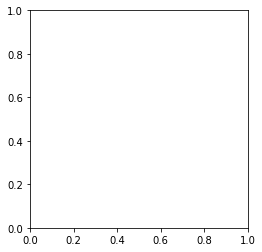

In [38]:
for i in range(CONFIG.NUM_ITERATIONS):
    _ = sess.run(train_step)
    generated_image = sess.run(model['input'])
    if i%10==0 :
        Jt,Jc,Js = sess.run([J , J_content , J_style])
        print("Iterations " + str(i) + ":")
        print("Total cost = " + str(Jt))
        print("Content cost = "+ str(Jc))
        print("Style cost = " + str(Js))
        save_image(CONFIG.OUTPUT_DIR +'/'+ str(i) + ".png", generated_image)

save_image(CONFIG.OUTPUT_DIR + '/generated_image.jpg' , generated_image)